In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

This notebook analyzes the relationship between various factors and the timing of a user's first initiated interaction with another site. The factors considered fall into the categories of post frequency, multisite authorship, interactions received, and health condition categories.

In [3]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/"
assert os.path.exists(working_dir)

In [4]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [5]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [6]:
int_filepath = os.path.join(working_dir, "user_metadata/interaction_metadata.feather")
int_df = pd.read_feather(int_filepath)
int_df.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
0,322059,20005,guestbook,1371420989000,1371420989000,None,NaN,None,True
1,5968472,68593,guestbook,1371432498000,1371432498000,None,NaN,None,False
2,21573557,557835,guestbook,1371429583000,1371429583000,None,NaN,None,True
3,20049997,77628,guestbook,1371440716000,1371440716000,None,NaN,None,False
4,24353953,604503,guestbook,1371442462000,1371442462000,None,NaN,None,False


In [7]:
int_noself_df = int_df[~int_df.is_self_interaction]

In [8]:
int_noself_df = int_noself_df.sort_values(by='created_at', ascending=True)
init_df = int_noself_df.drop_duplicates(subset=['user_id', 'site_id'], keep='first')

In [9]:
first_user_initiations = int_noself_df.drop_duplicates(subset=['user_id'], keep='first')
assert len(first_user_initiations) == len(set(int_noself_df.user_id))

In [10]:
subset_start_timestamp = datetime.fromisoformat('2014-01-01').timestamp() * 1000
end_timestamp = datetime.fromisoformat('2016-06-01').timestamp() * 1000
initiations_in_time_range = init_df[(init_df.created_at >= subset_start_timestamp)&(init_df.created_at <= end_timestamp)]
initiations_in_time_range.head()

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
9933881,5135645,238716,amps,1388556151000,1388556151000,52c3af77a589b48b517ef2b1,1204.0,None,False
9933886,15878504,238716,amps,1388556151000,1388556151000,52c3af77a589b48b517ef2b1,1204.0,None,False
9933887,22239537,238716,amps,1388556151000,1388556151000,52c3af77a589b48b517ef2b1,1204.0,None,False
7302248,20146227,83093,amps,1388556206000,1388556206000,52c3afae4db9210a2f099e71,591.0,None,False
7302254,6665650,83093,amps,1388556206000,1388556206000,52c3afae4db9210a2f099e71,591.0,None,False


In [11]:
first_initiations_in_time_range = first_user_initiations[(first_user_initiations.created_at >= subset_start_timestamp)&(first_user_initiations.created_at <= end_timestamp)]
len(first_initiations_in_time_range), len(first_user_initiations), len(initiations_in_time_range), len(init_df)

(26126, 208820, 137789, 914602)

## Post frequency

In [12]:
# dictionary of first journal update times for each user
first_update_dict = int_df[int_df.int_type == 'journal'].groupby('user_id')['created_at'].agg(np.min).to_dict()
# dictionary of first initiation times per user, per site that they initiate an interaction with
#site_initiation_dict = first_initiations_in_time_range.groupby(by=['user_id', 'site_id'])['created_at'].agg(np.min).to_dict()
site_initiation_dict = {(user_id, site_id): created_at
  for user_id, site_id, created_at
  in zip(first_initiations_in_time_range.user_id, first_initiations_in_time_range.site_id, first_initiations_in_time_range.created_at) }
initiation_list = []
for key, val in site_initiation_dict.items():
    user_id, site_id = key
    first_initiation = val
    first_update = first_update_dict[user_id]
    initiation_list.append({'user_id': user_id,
                            'site_id': site_id,
                            'first_initiation': first_initiation,
                            'first_update': first_update})
initiation_df = pd.DataFrame(initiation_list)
# ms between user's first update and first initiation
initiation_df['ms_before_initiation'] = initiation_df.first_initiation -  initiation_df.first_update
initiation_df.head()

,user_id,site_id,first_initiation,first_update,ms_before_initiation
0,27800665,853871,1388558607000,1401693589000,-13134982000
1,11120609,853860,1388567467000,1288803540000,99763927000
2,3336096,854226,1388567812000,1210867122000,177700690000
3,21214391,840052,1388568191000,1372119970000,16448221000
4,26867927,853118,1388584081000,1375394744000,13189337000


Now we'll calculate a user's posts per month prior to their first initiation. Some users may not have authored a post prior to their first initiated interaction.

In [13]:
# get journal posts for all users
journal_posts = int_df[(int_df.int_type == 'journal') & (int_df.is_self_interaction)]

# filter out users who don't have any initiations in sample to speed things up a little
posts_df = journal_posts[journal_posts.user_id.isin(list(initiation_df.user_id))]
posts_dict = {key: group['created_at'].values for key, group in posts_df.groupby('user_id')}

In [14]:
# get counts of journal posts before initiation with each site user initiations an interaction with

def count_posts_pre_initiation(row):
    first_initiation = row.first_initiation
    user_id = row.user_id
    num_posts = sum(1 for x in posts_dict[user_id] if x < first_initiation)
    return num_posts

initiation_df['pre_initiation_posts'] = initiation_df.apply(count_posts_pre_initiation, axis=1)
initiation_df.head(10)

,user_id,site_id,first_initiation,first_update,ms_before_initiation,pre_initiation_posts
0,27800665,853871,1388558607000,1401693589000,-13134982000,0
1,11120609,853860,1388567467000,1288803540000,99763927000,73
2,3336096,854226,1388567812000,1210867122000,177700690000,34
3,21214391,840052,1388568191000,1372119970000,16448221000,14
4,26867927,853118,1388584081000,1375394744000,13189337000,1
5,27395402,840388,1388587493000,1408407465000,-19819972000,0
6,7290433,829034,1388589422000,1284300780000,104288642000,17
7,23016003,28966,1388591402000,1349656920000,38934482000,29
8,15417187,839807,1388591470000,1458510470000,-69919000000,0
9,18249961,853578,1388593140000,1324442040000,64151100000,3


In [15]:
initiation_df['months_before_initiation'] = initiation_df['ms_before_initiation'] / (1000 * 60 * 60 * 24 * 30)
# masking here is to avoid division by 0 issues
posts_per_month = (initiation_df.pre_initiation_posts/initiation_df.months_before_initiation.mask(initiation_df.months_before_initiation==0)).fillna(0)
# posts_per_month: posts user authors per month before their first initiation with each site they initiate an interaction with
initiation_df['posts_per_month'] = posts_per_month
initiation_df.head()

,user_id,site_id,first_initiation,first_update,ms_before_initiation,pre_initiation_posts,months_before_initiation,posts_per_month
0,27800665,853871,1388558607000,1401693589000,-13134982000,0,-5.067508,-0.000000
1,11120609,853860,1388567467000,1288803540000,99763927000,73,38.489169,1.896637
2,3336096,854226,1388567812000,1210867122000,177700690000,34,68.557365,0.495935
3,21214391,840052,1388568191000,1372119970000,16448221000,14,6.345764,2.206196
4,26867927,853118,1388584081000,1375394744000,13189337000,1,5.088479,0.196522


In [16]:
# perform OLS regression analyzing relationship between first initiation user makes with the first site
# they interact with

model = smf.ols(formula='months_before_initiation ~ posts_per_month', data=initiation_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     29.98
Date:                      Thu, 02 Jan 2020   Prob (F-statistic):           4.40e-08
Time:                              15:50:01   Log-Likelihood:            -1.2162e+05
No. Observations:                     26126   AIC:                         2.432e+05
Df Residuals:                         26124   BIC:                         2.433e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          16.1100      0.158    102.153      0.000      15.801      16.419
posts_per_month    -0.0058      0.001     -5.475      0.000      -0.008      -0.004
==============================================================================
Omnibus:                    15386.126   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           545277.672
Skew:                           2.253   Prob(JB):                         0.00
Kurtosis:                      24.923   Cond. No.                         149.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# perform separate analysis for users who initiate post authorship
post_authorship = initiation_df[initiation_df['ms_before_initiation'] >= 0]
model = smf.ols(formula='months_before_initiation ~ posts_per_month', data=post_authorship)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.003
Model:                                  OLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     67.27
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           2.50e-16
Time:                              14:43:35   Log-Likelihood:                -95762.
No. Observations:                     20687   AIC:                         1.915e+05
Df Residuals:                         20685   BIC:                         1.915e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          22.4196      0.173    129.785      0.000      22.081      22.758
posts_per_month    -0.0085      0.001     -8.202      0.000      -0.010      -0.006
==============================================================================
Omnibus:                    13882.049   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           725868.012
Skew:                           2.608   Prob(JB):                         0.00
Kurtosis:                      31.547   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Received interactions

The next cells analyze the relationship between first initiated interactions by a user with interactions that the user has received.

We'll say a user has received an interaction if another user interacts with a site that they author. Specifically, if user A interacts with site X at time t, and user B has posted a journal update on site X before time t, then user B received an interaction from user A.

In [16]:
# make df where indices are user_id, site_id, and the time that the user created their first post on that site
site_authors_df = journal_posts.groupby(['user_id', 'site_id']).created_at.min().to_frame()
site_authors_df

created_at
user_id  site_id               
0        44       1275396300000
         102      1281316080000
         308      1289100900000
         664      1277917440000
         670      1275939360000
...                         ...
40993457 1334754  1549824535000
40993461 1334748  1549823328000
40993497 1334751  1549824366000
40993512 1334762  1549825496000
40993615 1334756  1549825116000

[758857 rows x 1 columns]

In [17]:
# make author_dict where key = user_id and val = {site1: first_update_authored_by_user, ...
site_authors_dict = {l: site_authors_df.xs(l)['created_at'].to_dict()
                     for l in site_authors_df.index.levels[0]}

In [18]:
# create a dict where key = site_id and val = [timestamps representing interactions that a user initiated with this site]
site_interactions_dict = int_df[~int_df.is_self_interaction].groupby('site_id')['created_at'].apply(list).to_dict()

In [19]:
# get list of sites user_id has authored a journal post on at time (time=None to get all sites a user has authored)
def get_sites(user_id, time = None):
    potential_sites = site_authors_dict[user_id]
    if time:
        sites = [k for k, v in potential_sites.items() if v <= time]
    else:
        sites = [k for k, v in potential_sites.items()]
    return sites

# gets dictionary of interactions where key = site that user has authored a post on (at time t) and val = [int1, int2, ...]
def get_ints(user_id, time):
    potential_sites = site_authors_dict[user_id]
    # only care about sites that have received interactions after user posted a journal post and before time t (param)
    sites_authored_dict = {site: authorship_time
                           for site, authorship_time in potential_sites.items()
                           if authorship_time <= time and site in site_interactions_dict}
    
    ints_received_dict = {site: [i for i in site_interactions_dict[site] if i >= first_authored]
                          for site, first_authored in sites_authored_dict.items()}
    return ints_received_dict

In [20]:
# first initiation: first interaction initiated by user i with a site j
# first interaction: first time a site that user i authors receives an interaction 

interaction_list = []
for key, val in site_initiation_dict.items():
    user_id, site_id = key
    first_initiation = val
    first_update = first_update_dict[user_id]
    # get dict of all ints received where key = site, val = [int1, int2, ...]
    # this is different from site_interactions_dict because we only want to know about interactions received
    # after user has made a post on that site
    ints_received_dict = get_ints(user_id, first_initiation)
    # get list of first interactions received on each site user has authored
    first_ints_received = [min(ints_list) for site, ints_list in ints_received_dict.items() if ints_list != []]
    # pick the first interaction from that list of first interactions
    first_int_received = min(first_ints_received) if first_ints_received != [] else 0
    first_int_to_first_update = first_int_received - first_update
    # similar steps as above but want last interactions instead
    most_recent_ints = [max(ints_list) for site, ints_list in ints_received_dict.items() if ints_list != []]
    most_recent_int = max(most_recent_ints) if most_recent_ints != [] else 0
    # count of all ints received across sites
    num_ints_received = sum(len(ints_list) for site, ints_list in ints_received_dict.items())
    ints_pre_init = [i for site, ints_list in ints_received_dict.items()
                     for i in ints_list if i < first_initiation]
    num_ints_pre_init = len(ints_pre_init)
    dummy = 1 if first_initiation < first_int_received else 0
    interaction_list.append({'user_id': user_id,
                             'first_initiation': first_initiation,
                             'first_int_received': first_int_received,
                             'most_recent_int_received': most_recent_int,
                             'num_ints_received': num_ints_received,
                             'num_ints_pre_init': num_ints_pre_init,
                             'is_first_initiation_pre_interaction': dummy,
                             'first_int_to_first_update': first_int_to_first_update})
interaction_df = pd.DataFrame(interaction_list) 
interaction_df.head()

,user_id,first_initiation,first_int_received,most_recent_int_received,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update
0,27800665,1388558607000,0,0,0,0,0,-1401693589000
1,11120609,1388567467000,1289601783000,1308075559000,17,17,0,798243000
2,3336096,1388567812000,1210944434000,1224018680000,3,3,0,77312000
3,21214391,1388568191000,0,0,0,0,0,-1372119970000
4,26867927,1388584081000,1375413871000,1401490978000,6,4,0,19127000


In [21]:
# how many users initiated their first interaction before making any posts?
interaction_df['is_first_initiation_pre_authorship'] = initiation_df.eval('ms_before_initiation < 0')
interaction_df.head()

,user_id,first_initiation,first_int_received,most_recent_int_received,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship
0,27800665,1388558607000,0,0,0,0,0,-1401693589000,True
1,11120609,1388567467000,1289601783000,1308075559000,17,17,0,798243000,False
2,3336096,1388567812000,1210944434000,1224018680000,3,3,0,77312000,False
3,21214391,1388568191000,0,0,0,0,0,-1372119970000,False
4,26867927,1388584081000,1375413871000,1401490978000,6,4,0,19127000,False


In [22]:
interaction_df = pd.merge(initiation_df[['user_id', 'first_update', 'months_before_initiation', 'posts_per_month']],
                          interaction_df, on='user_id')
interaction_df['has_received_int'] = np.sign(interaction_df['num_ints_received'])
interaction_df.head()

,user_id,first_update,months_before_initiation,posts_per_month,first_initiation,first_int_received,most_recent_int_received,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship,has_received_int
0,27800665,1401693589000,-5.067508,-0.000000,1388558607000,0,0,0,0,0,-1401693589000,True,0
1,11120609,1288803540000,38.489169,1.896637,1388567467000,1289601783000,1308075559000,17,17,0,798243000,False,1
2,3336096,1210867122000,68.557365,0.495935,1388567812000,1210944434000,1224018680000,3,3,0,77312000,False,1
3,21214391,1372119970000,6.345764,2.206196,1388568191000,0,0,0,0,0,-1372119970000,False,0
4,26867927,1375394744000,5.088479,0.196522,1388584081000,1375413871000,1401490978000,6,4,0,19127000,False,1


In [23]:
interaction_df['first_int_received_to_first_init'] = ((interaction_df.first_initiation*interaction_df.has_received_int) -
                                                      interaction_df.first_int_received) / (1000*60*60*24*30)
interaction_df['recent_int_received_to_first_init'] = ((interaction_df.first_initiation*interaction_df.has_received_int) -
                                                       interaction_df.most_recent_int_received) / (1000*60*60*24*30)
interaction_df['first_int_to_first_update'] = interaction_df.first_int_to_first_update / (1000*60*60*24*30)
interaction_df.head()

,user_id,first_update,months_before_initiation,posts_per_month,first_initiation,first_int_received,most_recent_int_received,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship,has_received_int,first_int_received_to_first_init,recent_int_received_to_first_init
0,27800665,1401693589000,-5.067508,-0.000000,1388558607000,0,0,0,0,0,-540.776848,True,0,0.000000,0.000000
1,11120609,1288803540000,38.489169,1.896637,1388567467000,1289601783000,1308075559000,17,17,0,0.307964,False,1,38.181205,31.053977
2,3336096,1210867122000,68.557365,0.495935,1388567812000,1210944434000,1224018680000,3,3,0,0.029827,False,1,68.527538,63.483461
3,21214391,1372119970000,6.345764,2.206196,1388568191000,0,0,0,0,0,-529.367272,False,0,0.000000,0.000000
4,26867927,1375394744000,5.088479,0.196522,1388584081000,1375413871000,1401490978000,6,4,0,0.007379,False,1,5.081100,-4.979513


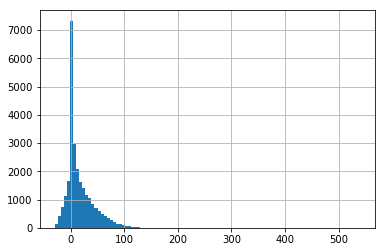

In [33]:
# plot months before user's first initiation 
months_before_initiation = initiation_df.groupby('user_id')['months_before_initiation'].agg(np.min)
months_before_initiation.hist(bins=100)

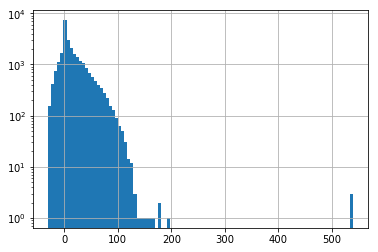

In [34]:
months_before_initiation.hist(bins=100, log = True)

In [35]:
# get frac of users where first initiation is pre authorship
num_users = initiation_df['user_id'].nunique()
first_init_pre_author = interaction_df[interaction_df.is_first_initiation_pre_authorship == 1]['user_id'].nunique()
first_init_pre_author/num_users, num_users

(0.20818341881650462, 26126)

In [36]:
# fraction of users whose first initiation is post authorship pre interaction
first_init_post_author_pre_int = interaction_df[(interaction_df.is_first_initiation_pre_authorship == 0) & (interaction_df.is_first_initiation_pre_interaction==1)].shape[0]
first_init_post_author_pre_int/num_users

0.03720431753808467

In [37]:
# fraction of users whose first initiation is post authorship post interaction
first_init_post_author_post_int = interaction_df[(interaction_df.is_first_initiation_pre_authorship == 0) & (interaction_df.is_first_initiation_pre_interaction==0)].shape[0]
first_init_post_author_post_int/num_users

0.7546122636454107

In [26]:
interaction_df['num_ints_post_init'] = interaction_df['num_ints_received'] - interaction_df['num_ints_pre_init']

# f = 'months_before_initiation ~ first_int_to_first_update : has_received_int \
#     + recent_int_received_to_first_init : has_received_int + num_ints_post_init + num_ints_pre_init : has_received_int \
#     + has_received_int'

f1 = 'months_before_initiation ~ has_received_int'
model = smf.ols(formula=f1, data = interaction_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.018
Model:                                  OLS   Adj. R-squared:                  0.018
Method:                       Least Squares   F-statistic:                     478.5
Date:                      Thu, 02 Jan 2020   Prob (F-statistic):          3.92e-105
Time:                              15:57:08   Log-Likelihood:            -1.2140e+05
No. Observations:                     26126   AIC:                         2.428e+05
Df Residuals:                         26124   BIC:                         2.428e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.3565      0.230     53.699      0.000      11.906      12.808
has_received_int     6.8497      0.313     21.875      0.000       6.236       7.463
==============================================================================
Omnibus:                    16123.230   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           604273.214
Skew:                           2.398   Prob(JB):                         0.00
Kurtosis:                      26.067   Cond. No.                         2.72
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# testing separately for ~is_first_initiation_pre_authorship
# f = 'months_before_initiation ~ first_int_received_to_first_init : has_received_int + \
#     recent_int_received_to_first_init : has_received_int + num_ints_received + num_ints_pre_init'
f1 = 'months_before_initiation ~ has_received_int + first_int_to_first_update : has_received_int '
model = smf.ols(formula=f1, data = interaction_df[~interaction_df.is_first_initiation_pre_authorship])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.078
Model:                                  OLS   Adj. R-squared:                  0.078
Method:                       Least Squares   F-statistic:                     875.1
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):               0.00
Time:                              15:00:31   Log-Likelihood:                -94955.
No. Observations:                     20687   AIC:                         1.899e+05
Df Residuals:                         20684   BIC:                         1.899e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     28.9966      0.294     98.663      0.000      28.421      29.573
has_received_int                             -11.1053      0.358    -30.994      0.000     -11.808     -10.403
first_int_to_first_update:has_received_int     0.7846      0.025     31.517      0.000       0.736       0.833
==============================================================================
Omnibus:                    12051.058   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           418825.693
Skew:                           2.221   Prob(JB):                         0.00
Kurtosis:                      24.591   Cond. No.                         18.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# correlations between all the variables examined
interaction_df.corr()

,user_id,first_update,months_before_initiation,posts_per_month,first_initiation,first_int_received,most_recent_int_received,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship,has_received_int,first_int_received_to_first_init,recent_int_received_to_first_init,num_ints_post_init
user_id,1.000000,0.786398,-0.743882,0.032253,0.116433,0.003520,0.001653,0.037191,0.000243,0.095790,-0.070696,0.243685,-0.032371,-0.493861,-0.429364,0.061191
first_update,0.786398,1.000000,-0.944379,0.031393,0.152738,-0.067769,-0.069763,0.026120,-0.015791,0.086997,-0.161361,0.421520,-0.108353,-0.572495,-0.477776,0.060262
months_before_initiation,-0.743882,-0.944379,1.000000,-0.033857,0.180757,0.098049,0.099460,-0.029032,0.016017,-0.084444,0.186067,-0.479924,0.134120,0.603334,0.504691,-0.065319
posts_per_month,0.032253,0.031393,-0.033857,1.000000,-0.007859,0.031803,0.031330,0.010066,-0.000654,0.088498,0.028497,-0.032347,0.029208,-0.029662,-0.030657,0.017341
first_initiation,0.116433,0.152738,0.180757,-0.007859,1.000000,0.091975,0.090248,-0.009128,0.000909,0.006420,0.076571,-0.181587,0.078994,0.100926,0.087766,-0.016066
first_int_received,0.003520,-0.067769,0.098049,0.031803,0.091975,1.000000,0.999014,0.195604,0.159850,0.196633,0.995562,-0.554500,0.998024,0.425016,0.093905,0.150085
most_recent_int_received,0.001653,-0.069763,0.099460,0.031330,0.090248,0.999014,1.000000,0.208670,0.168984,0.193066,0.994775,-0.554081,0.997270,0.427270,0.069397,0.161784
num_ints_received,0.037191,0.026120,-0.029032,0.010066,-0.009128,0.195604,0.208670,1.000000,0.811168,-0.013271,0.191021,-0.106889,0.192385,0.028341,-0.212830,0.773841
num_ints_pre_init,0.000243,-0.015791,0.016017,-0.000654,0.000909,0.159850,0.168984,0.811168,1.000000,-0.034253,0.159608,-0.089348,0.160814,0.080649,-0.100043,0.257306
is_first_initiation_pre_interaction,0.095790,0.086997,-0.084444,0.088498,0.006420,0.196633,0.193066,-0.013271,-0.034253,1.000000,0.186297,-0.100795,0.181418,-0.143039,-0.143727,0.015170


## Multisite authorship data

In [38]:
num_sites_list = []
for key, val in site_initiation_dict.items():
    user_id, site_id = key
    first_initiation = val
    sites_authored_pre_init = get_sites(user_id, first_initiation)
    sites_authored_any_time = get_sites(user_id)
    is_multiauthor = 1 if len(sites_authored_pre_init) > 1 else 0
    will_become_multiauthor = 1 if len(sites_authored_any_time) > 1 else 0
    num_sites_pre_init = len(sites_authored_pre_init)
    num_sites_any_time = len(sites_authored_any_time)
    num_sites_list.append({'user_id': user_id,
                           'num_sites_pre_init': num_sites_pre_init,
                           'num_sites_any_time': num_sites_any_time,
                           'is_multiauthor': is_multiauthor,
                           'will_become_multiauthor': will_become_multiauthor})
num_sites_df = pd.DataFrame(num_sites_list)
num_sites_df.head()

,user_id,num_sites_pre_init,num_sites_any_time,is_multiauthor,will_become_multiauthor
0,27800665,0,1,0,0
1,11120609,1,1,0,0
2,3336096,1,1,0,0
3,21214391,1,1,0,0
4,26867927,1,1,0,0


In [39]:
# want to see how first initiation relates to multiauthor features
multi_author_df = pd.merge(initiation_df[['user_id', 'first_initiation', 'first_update', 'months_before_initiation']],
                           num_sites_df, on='user_id')
multi_author_df.head()

,user_id,first_initiation,first_update,months_before_initiation,num_sites_pre_init,num_sites_any_time,is_multiauthor,will_become_multiauthor
0,27800665,1388558607000,1401693589000,-5.067508,0,1,0,0
1,11120609,1388567467000,1288803540000,38.489169,1,1,0,0
2,3336096,1388567812000,1210867122000,68.557365,1,1,0,0
3,21214391,1388568191000,1372119970000,6.345764,1,1,0,0
4,26867927,1388584081000,1375394744000,5.088479,1,1,0,0


In [40]:
# relationship between time before user initiates first interaction and whether they have multiple sites
# at that time
model = smf.ols(formula = 'months_before_initiation ~ is_multiauthor', data = multi_author_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.017
Model:                                  OLS   Adj. R-squared:                  0.017
Method:                       Least Squares   F-statistic:                     455.6
Date:                      Tue, 31 Dec 2019   Prob (F-statistic):          3.20e-100
Time:                              19:50:46   Log-Likelihood:            -1.2141e+05
No. Observations:                     26126   AIC:                         2.428e+05
Df Residuals:                         26124   BIC:                         2.428e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         15.5500      0.158     98.472      0.000      15.240      15.859
is_multiauthor    22.4666      1.053     21.344      0.000      20.403      24.530
==============================================================================
Omnibus:                    15282.236   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           528466.286
Skew:                           2.238   Prob(JB):                         0.00
Kurtosis:                      24.574   Cond. No.                         6.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# relationship between time before user initiates first interaction and whether they will EVER have multiple sites
model = smf.ols(formula = 'months_before_initiation ~ will_become_multiauthor', data=multi_author_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     101.6
Date:                      Tue, 31 Dec 2019   Prob (F-statistic):           7.53e-24
Time:                              19:50:47   Log-Likelihood:            -1.2159e+05
No. Observations:                     26126   AIC:                         2.432e+05
Df Residuals:                         26124   BIC:                         2.432e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  15.6709      0.162     96.886      0.000      15.354      15.988
will_become_multiauthor     6.9083      0.685     10.079      0.000       5.565       8.252
==============================================================================
Omnibus:                    15310.877   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           536465.068
Skew:                           2.240   Prob(JB):                         0.00
Kurtosis:                      24.742   Cond. No.                         4.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# relationship between time before user initiates first interaction and number of sites they've posted on 
# at that time
model = smf.ols(formula = 'months_before_initiation ~ num_sites_pre_init : is_multiauthor', data=multi_author_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.017
Model:                                  OLS   Adj. R-squared:                  0.017
Method:                       Least Squares   F-statistic:                     449.5
Date:                      Tue, 31 Dec 2019   Prob (F-statistic):           6.21e-99
Time:                              19:50:48   Log-Likelihood:            -1.2141e+05
No. Observations:                     26126   AIC:                         2.428e+05
Df Residuals:                         26124   BIC:                         2.428e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            15.5646      0.158     98.602      0.000      15.255      15.874
num_sites_pre_init:is_multiauthor    10.3459      0.488     21.202      0.000       9.390      11.302
==============================================================================
Omnibus:                    15303.806   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           531944.619
Skew:                           2.241   Prob(JB):                         0.00
Kurtosis:                      24.646   Cond. No.                         3.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# relationship between time before user initiates first interaction and number of sites they will ever post on
model = smf.ols(formula = 'months_before_initiation ~ num_sites_any_time : will_become_multiauthor', data=multi_author_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     96.98
Date:                      Tue, 31 Dec 2019   Prob (F-statistic):           7.69e-23
Time:                              19:50:49   Log-Likelihood:            -1.2159e+05
No. Observations:                     26126   AIC:                         2.432e+05
Df Residuals:                         26124   BIC:                         2.432e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     15.6935      0.161     97.214      0.000      15.377      16.010
num_sites_any_time:will_become_multiauthor     3.0310      0.308      9.848      0.000       2.428       3.634
==============================================================================
Omnibus:                    15322.039   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           538082.308
Skew:                           2.242   Prob(JB):                         0.00
Kurtosis:                      24.776   Cond. No.                         2.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# putting them all together
model = smf.ols(formula = 'months_before_initiation ~ num_sites_pre_init : is_multiauthor \
                + num_sites_any_time : will_become_multiauthor', data=multi_author_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.018
Model:                                  OLS   Adj. R-squared:                  0.018
Method:                       Least Squares   F-statistic:                     236.7
Date:                      Tue, 31 Dec 2019   Prob (F-statistic):          1.36e-102
Time:                              19:50:50   Log-Likelihood:            -1.2140e+05
No. Observations:                     26126   AIC:                         2.428e+05
Df Residuals:                         26123   BIC:                         2.428e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     15.7012      0.160     97.955      0.000      15.387      16.015
num_sites_pre_init:is_multiauthor             12.3248      0.636     19.364      0.000      11.077      13.572
num_sites_any_time:will_become_multiauthor    -1.9300      0.399     -4.840      0.000      -2.712      -1.148
==============================================================================
Omnibus:                    15305.999   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           532344.703
Skew:                           2.242   Prob(JB):                         0.00
Kurtosis:                      24.655   Cond. No.                         4.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# separate testing for users initiating pre authorship
model = smf.ols(formula = 'months_before_initiation ~ num_sites_pre_init : is_multiauthor \
                + num_sites_any_time : will_become_multiauthor',
                data=multi_author_df[multi_author_df['num_sites_pre_init'] == 0])
res = model.fit()
res.summary()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1633: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     4.056
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):             0.0441
Time:                              15:16:23   Log-Likelihood:                -18448.
No. Observations:                      5439   AIC:                         3.690e+04
Df Residuals:                          5437   BIC:                         3.691e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -7.8127      0.100    -78.127      0.000      -8.009      -7.617
num_sites_pre_init:is_multiauthor                   0          0        nan        nan           0           0
num_sites_any_time:will_become_multiauthor     0.3913      0.194      2.014      0.044       0.010       0.772
==============================================================================
Omnibus:                      516.814   Durbin-Watson:                   1.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              666.494
Skew:                          -0.850   Prob(JB):                    1.87e-145
Kurtosis:                       2.774   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [49]:
# separate testing for users initiating post authorship
model = smf.ols(formula = 'months_before_initiation ~ num_sites_pre_init : is_multiauthor \
                + num_sites_any_time : will_become_multiauthor',
                data=multi_author_df[multi_author_df['num_sites_pre_init'] > 0])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.012
Model:                                  OLS   Adj. R-squared:                  0.012
Method:                       Least Squares   F-statistic:                     122.9
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           8.58e-54
Time:                              15:17:04   Log-Likelihood:                -95673.
No. Observations:                     20687   AIC:                         1.914e+05
Df Residuals:                         20684   BIC:                         1.914e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     21.9006      0.176    124.234      0.000      21.555      22.246
num_sites_pre_init:is_multiauthor              8.0078      0.690     11.607      0.000       6.655       9.360
num_sites_any_time:will_become_multiauthor    -0.5065      0.482     -1.050      0.294      -1.452       0.439
==============================================================================
Omnibus:                    13755.265   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           702838.568
Skew:                           2.578   Prob(JB):                         0.00
Kurtosis:                      31.086   Cond. No.                         4.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Health condition data

In [24]:
metadata_dir = '/home/srivbane/shared/caringbridge/data/derived/site_metadata'
metadata_filepath = os.path.join(metadata_dir, "site_metadata.feather")
metadata_df = pd.read_feather(metadata_filepath)
metadata_df.head()

,age,created_at,hasVisitorInvite,healthCondition_category,healthCondition_custom,healthCondition_name,ip,isDeleted,isForSelf,isGoogleable,...,numPhotos,numTasks,numTributes,numVisitorInvites,privacy,publish_date,site_id,title,updated_at,visits
0,adult,1257785950000,None,Surgery/Transplantation,None,Surgery,None,None,None,None,...,3,0,0,-1,medium,0,154247,Pat Collins,1369952505000,50
1,teen,1117605558000,None,None,None,None,None,None,None,None,...,12,0,0,-1,medium,0,1,Carly's Updates,1371330918000,22897
2,adult,1257786252000,None,Cardiovascular/Stroke,None,Stroke,None,None,None,None,...,0,0,0,-1,medium,0,154248,Marry Casey,1334429906000,329
3,baby,1118087754000,None,None,None,None,None,None,None,None,...,3,0,0,-1,medium,0,2,Joanna Lee,1371138394000,8447
4,adult,1257786493000,None,Injury,None,Motor Vehicle Injury,None,None,None,None,...,25,0,0,-1,medium,0,154249,Marty Mitchell,1365477419000,789


In [25]:
metadata_df['healthCondition_category'].value_counts()

Cancer                        139104
custom                         37262
                               22413
Surgery/Transplantation        19268
Cardiovascular/Stroke          17278
Injury                         16105
Neurological Condition         12536
Infant/Childbirth              10438
Other                           7638
Congenital/Immune Disorder      3151
Condition Unknown               2988
Name: healthCondition_category, dtype: int64

In [26]:
# convert some values before continuing
# treating '' and None as 'None'
# treating 'custom' and 'Other' both as 'Other'
metadata_df.loc[metadata_df['healthCondition_category'].isnull(), 'healthCondition_category'] = 'None'
metadata_df['healthCondition_category'].replace('', 'None', inplace=True)
metadata_df['healthCondition_category'].replace('custom', 'Other', inplace=True)
metadata_df['healthCondition_category'].value_counts()

None                          575175
Cancer                        139104
Other                          44900
Surgery/Transplantation        19268
Cardiovascular/Stroke          17278
Injury                         16105
Neurological Condition         12536
Infant/Childbirth              10438
Congenital/Immune Disorder      3151
Condition Unknown               2988
Name: healthCondition_category, dtype: int64

In [27]:
health_conditions_df = pd.merge(initiation_df[['user_id','site_id','first_update','first_initiation','months_before_initiation']],
                                metadata_df[['site_id', 'healthCondition_category']], how='left', on='site_id')
health_conditions_df.rename(columns={'healthCondition_category': 'site_assigned_condition'},inplace=True)
health_conditions_df.head()

,user_id,site_id,first_update,first_initiation,months_before_initiation,site_assigned_condition
0,27800665,853871,1401693589000,1388558607000,-5.067508,None
1,11120609,853860,1288803540000,1388567467000,38.489169,None
2,3336096,854226,1210867122000,1388567812000,68.557365,Neurological Condition
3,21214391,840052,1372119970000,1388568191000,6.345764,None
4,26867927,853118,1375394744000,1388584081000,5.088479,Surgery/Transplantation


**Creating a dataframe for all users with assigned health condition categories**

This section includes users who never initiate an interaction, unlike some of the other calculations done previously.

In [28]:
health_cond_dict = metadata_df.set_index('site_id').to_dict()['healthCondition_category']

In [29]:
# these sites are missing from metadata dataframe
int_df[~int_df['site_id'].isin(health_cond_dict.keys())]

,user_id,site_id,int_type,created_at,updated_at,journal_oid,site_index,is_nontrivial,is_self_interaction
34831,10329,890,guestbook,1119483162000,1119483162000,None,NaN,None,False
60116,29126,1538,guestbook,1120882875000,1120882875000,None,NaN,None,False
60264,36459,1538,guestbook,1121437787000,1121437787000,None,NaN,None,False
67223,38076,1914,guestbook,1122771755000,1122771755000,None,NaN,None,False
313158,236200,7254,guestbook,1135710491000,1135710491000,None,NaN,None,False
10564627,0,1455,journal,1120513202000,1120513202000,51bdf42c6ca004644f012be9,0.0,False,True
10634083,0,2840,journal,1123534762000,1123534762000,51bdf47c6ca004795000a920,0.0,False,True
10634225,0,2842,journal,1123535740000,1123535740000,51bdf47c6ca004795000a923,0.0,False,True
10634226,0,2843,journal,1123536401000,1123536401000,51bdf47c6ca004795000a926,0.0,False,True
10634228,0,2845,journal,1123538350000,1123538350000,51bdf47c6ca004795000a92b,0.0,False,True


In [30]:
health_cond_list = []
# looking at all users and all the sites they've posted on
for key, val in site_authors_dict.items():
    user_id = key
    site_dict = val
    for site in site_dict.keys():
        try:
            health_cond = health_cond_dict[site]
            health_cond_list.append({'user_id': user_id, 'site_id': site, 'health_cond': health_cond})
        except KeyError:
            print (site) # these sites are ignored because they're not in the metadata_df
all_authors_health_cond_df = pd.DataFrame(health_cond_list) 
all_authors_health_cond_df.head()

1455
2840
2842
2843
2845
3131
8815
24875
15002
100240
1256993


,user_id,site_id,health_cond
0,0,44,Cancer
1,0,102,Condition Unknown
2,0,308,Cancer
3,0,664,None
4,0,670,Cardiovascular/Stroke


In [74]:
all_authors_health_cond_df[all_authors_health_cond_df['user_id'] == 10307]

,user_id,site_id,health_cond
11127,10307,825601,None
11128,10307,1001611,None
11129,10307,1007445,None
11130,10307,1145566,Cancer
11131,10307,1302516,Neurological Condition


In [31]:
valid_users_health_conds = all_authors_health_cond_df[all_authors_health_cond_df['user_id'].isin(valid_user_ids)]
len(set(valid_users_health_conds.user_id))

362345

In [32]:
# condition_counts = all_authors_health_cond_df.groupby('user_id')['health_cond'].agg({'num_sites':'count',
#                                                                                      'distinct_conditions':'nunique'})
# condition_counts.head()

condition_counts = valid_users_health_conds.groupby('user_id')['health_cond'].agg({'num_sites':'count',
                                                                                     'distinct_conditions':'nunique'})
condition_counts.head()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  


,num_sites,distinct_conditions
user_id,,
1,1,1
2,1,1
6,1,1
12,1,1
15,1,1


Next are some calculations about how many users have ambiguous health conditions (defined as having multiple sites with distinct health conditions)

In [33]:
# num users who authored posts on sites with different conditions (including None)
num_multi_condition = condition_counts[condition_counts.distinct_conditions > 1].shape[0]
num_multi_condition

11102

In [34]:
# total number of authors
# num_users = all_authors_health_cond_df.nunique()['user_id']
# num_users

num_users = valid_users_health_conds.nunique()['user_id']
num_users

362345

In [35]:
# number of users who author posts on multiple sites at any point
multi_author_count = condition_counts[condition_counts.num_sites > 1].shape[0]
multi_author_count

20057

In [36]:
percent_multiauthor = multi_author_count/num_users
percent_multiauthor

0.05535332349004402

In [37]:
percent_multi_condition_all_users = num_multi_condition/num_users
percent_multi_condition_all_users

0.03063930784197381

In [38]:
percent_multi_condition_multisite = num_multi_condition/multi_author_count
percent_multi_condition_multisite

0.5535224609861894

Now we're going to assign health condition categories to users with multiple sites. The method to do this is as follows:
1. If an author has multiple sites that all have the same health condition category, assign that category to the user.
2. If the sites do _not_ have the same health condition category, choose from the non-None conditions.

In [39]:
# first assign conditions to authors that only have 1 site (so 1 possible assignment)
single_site_authors = valid_users_health_conds[['user_id', 'health_cond']].drop_duplicates(subset='user_id', keep = False)
single_site_assignment_dict = dict(zip(single_site_authors.user_id, single_site_authors.health_cond))
single_site_authors.head()

,user_id,health_cond
9834,1,None
9835,2,None
9839,6,None
9844,12,None
9847,15,None


In [40]:
multisite_conditions_df = valid_users_health_conds[valid_users_health_conds.duplicated(['user_id'])]
multisite_conditions_df['user_id'].nunique()

20057

In [41]:
multisite_conditions_df.head()

,user_id,site_id,health_cond
9849,16,54579,None
9863,29,832207,None
9866,31,121588,Surgery/Transplantation
9873,37,146716,Other
9876,39,3374,None


In [100]:
none_conditions = ['None', 'Condition Unknown']

def assign_condition(df):
    candidate_conds = list(set(df.health_cond.values))
    df['num_candidates'] = len(candidate_conds)
    preferred_candidates = [c for c in candidate_conds if c not in none_conditions]
    df['num_preferred'] = len(preferred_candidates)
    if preferred_candidates == []:
        cands = candidate_conds
    else:
        cands = preferred_candidates
    assigned = cands[0]
    df['health_cond'] = assigned
    return df

In [101]:
assigned_multisite = multisite_conditions_df.groupby('user_id').apply(assign_condition).drop_duplicates(subset='user_id',
                                                                                                        keep='first')
assigned_multisite

,user_id,site_id,health_cond,num_candidates,num_preferred
9849,16,54579,None,1,0
9863,29,832207,None,1,0
9866,31,121588,Surgery/Transplantation,1,1
9873,37,146716,Other,1,1
9876,39,3374,None,1,0
...,...,...,...,...,...
660220,33518627,1219740,None,1,0
660299,33520924,1256618,Surgery/Transplantation,1,1
660523,33527287,1170839,None,1,0
660812,33535419,1159111,None,1,0


In [102]:
assigned_multisite[assigned_multisite['num_preferred'] > 1].shape

(446, 5)

In [103]:
assigned_multisite[assigned_multisite['num_preferred'] > 2].shape

(46, 5)

In [104]:
assigned_multisite.sort_values(by='num_preferred', ascending=False).shape

(20057, 5)

In [105]:
assigned_multisite_dict = dict(zip(assigned_multisite.user_id, assigned_multisite.health_cond))
len(assigned_multisite_dict)

20057

In [106]:
assigned_health_cond_dict = {**assigned_multisite_dict, **single_site_assignment_dict}
len(assigned_health_cond_dict)

362345

In [107]:
assigned_cond_valid_users_df = pd.DataFrame(assigned_health_cond_dict.items(), columns=['user_id','assigned_health_cond'])
assigned_cond_valid_users_df

,user_id,assigned_health_cond
0,16,None
1,29,None
2,31,Surgery/Transplantation
3,37,Other
4,39,None
...,...,...
362340,33538845,None
362341,33538947,None
362342,33539304,Surgery/Transplantation
362343,33539356,None


In [108]:
health_cond_filepath = os.path.join(working_dir, "user_metadata/assigned_health_conditions.feather")
#assigned_health_cond_df.to_feather(health_cond_filepath)

In [109]:
# assigned_health_cond_df = pd.read_feather(health_cond_filepath)
# assigned_health_cond_df

assigned_health_cond_df = pd.read_feather(health_cond_filepath)
assigned_health_cond_df.head()

,user_id,assigned_health_cond
0,0,Cancer
1,10,None
2,16,None
3,29,None
4,31,Surgery/Transplantation


Now we're back to analyzing initiating authors, specifically looking at initiation timing with user health condition.

In [56]:
health_conditions_df = pd.merge(health_conditions_df, assigned_health_cond_df, how='left', on='user_id')
health_conditions_df.head()

,user_id,site_id,first_update,first_initiation,months_before_initiation,site_assigned_condition,assigned_health_cond
0,27800665,853871,1401693589000,1388558607000,-5.067508,None,Injury
1,11120609,853860,1288803540000,1388567467000,38.489169,None,Injury
2,3336096,854226,1210867122000,1388567812000,68.557365,Neurological Condition,None
3,21214391,840052,1372119970000,1388568191000,6.345764,None,Cancer
4,26867927,853118,1375394744000,1388584081000,5.088479,Surgery/Transplantation,None


In [57]:
health_conditions_df.rename(columns={'assigned_health_cond': 'user_assigned_condition'},inplace=True)
health_conditions_df.head()

,user_id,site_id,first_update,first_initiation,months_before_initiation,site_assigned_condition,user_assigned_condition
0,27800665,853871,1401693589000,1388558607000,-5.067508,None,Injury
1,11120609,853860,1288803540000,1388567467000,38.489169,None,Injury
2,3336096,854226,1210867122000,1388567812000,68.557365,Neurological Condition,None
3,21214391,840052,1372119970000,1388568191000,6.345764,None,Cancer
4,26867927,853118,1375394744000,1388584081000,5.088479,Surgery/Transplantation,None


In [58]:
# looking at months before initiation ~ user health condition 
model = smf.ols(formula= 'months_before_initiation ~ C(user_assigned_condition)', data=health_conditions_df)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.055
Model:                                  OLS   Adj. R-squared:                  0.055
Method:                       Least Squares   F-statistic:                     170.2
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):          4.73e-315
Time:                              15:19:42   Log-Likelihood:            -1.2089e+05
No. Observations:                     26126   AIC:                         2.418e+05
Df Residuals:                         26116   BIC:                         2.419e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   17.1707      0.271     63.405      0.000      16.640      17.701
C(user_assigned_condition)[T.Cardiovascular/Stroke]         -0.2905      0.829     -0.350      0.726      -1.916       1.335
C(user_assigned_condition)[T.Condition Unknown]             23.6139      2.729      8.652      0.000      18.264      28.964
C(user_assigned_condition)[T.Congenital/Immune Disorder]    -6.1928      1.922     -3.221      0.001      -9.961      -2.425
C(user_assigned_condition)[T.Infant/Childbirth]              2.8641      1.093      2.620      0.009       0.722       5.006
C(user_assigned_condition)[T.Injury]                         1.4229      0.912      1.561      0.119      -0.364       3.210
C(user_assigned_condition)[T.Neurological Condition]         2.4327      1.005      2.420      0.016       0.462       4.403
C(user_assigned_condition)[T.None]                          -5.3973      0.351    -15.364      0.000      -6.086      -4.709
C(user_assigned_condition)[T.Other]                         19.5918      0.724     27.052      0.000      18.172      21.011
C(user_assigned_condition)[T.Surgery/Transplantation]        5.7030      0.852      6.693      0.000       4.033       7.373
==============================================================================
Omnibus:                    16688.795   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           736878.082
Skew:                           2.472   Prob(JB):                         0.00
Kurtosis:                      28.544   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
# looking at months before initiation ~ user health condition  for pre authorship initiators
model = smf.ols(formula= 'months_before_initiation ~ C(user_assigned_condition)',
                data=health_conditions_df[health_conditions_df['months_before_initiation'] < 0])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.002
Model:                                  OLS   Adj. R-squared:                  0.000
Method:                       Least Squares   F-statistic:                     1.120
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):              0.344
Time:                              15:19:48   Log-Likelihood:                -18445.
No. Observations:                      5439   AIC:                         3.691e+04
Df Residuals:                          5429   BIC:                         3.698e+04
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   -7.8202      0.197    -39.779      0.000      -8.206      -7.435
C(user_assigned_condition)[T.Cardiovascular/Stroke]         -0.6511      0.548     -1.189      0.235      -1.725       0.423
C(user_assigned_condition)[T.Condition Unknown]              2.8772      7.196      0.400      0.689     -11.231      16.985
C(user_assigned_condition)[T.Congenital/Immune Disorder]     1.3394      1.287      1.041      0.298      -1.183       3.862
C(user_assigned_condition)[T.Infant/Childbirth]              1.2583      0.901      1.397      0.162      -0.507       3.024
C(user_assigned_condition)[T.Injury]                        -0.5384      0.629     -0.856      0.392      -1.771       0.695
C(user_assigned_condition)[T.Neurological Condition]        -0.3908      0.675     -0.579      0.563      -1.715       0.933
C(user_assigned_condition)[T.None]                           0.0988      0.233      0.424      0.672      -0.358       0.556
C(user_assigned_condition)[T.Other]                          1.4887      0.828      1.798      0.072      -0.134       3.112
C(user_assigned_condition)[T.Surgery/Transplantation]       -0.2618      0.629     -0.416      0.677      -1.495       0.971
==============================================================================
Omnibus:                      514.632   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              662.187
Skew:                          -0.847   Prob(JB):                    1.61e-144
Kurtosis:                       2.769   Cond. No.                         88.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
# looking at months before initiation ~ user health condition  for post authorship initiators
model = smf.ols(formula= 'months_before_initiation ~ C(user_assigned_condition)',
                data=health_conditions_df[health_conditions_df['months_before_initiation'] >= 0])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.043
Model:                                  OLS   Adj. R-squared:                  0.043
Method:                       Least Squares   F-statistic:                     104.4
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):          4.47e-192
Time:                              15:19:55   Log-Likelihood:                -95335.
No. Observations:                     20687   AIC:                         1.907e+05
Df Residuals:                         20677   BIC:                         1.908e+05
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                   21.9449      0.290     75.659      0.000      21.376      22.513
C(user_assigned_condition)[T.Cardiovascular/Stroke]          1.2176      0.907      1.343      0.179      -0.560       2.995
C(user_assigned_condition)[T.Condition Unknown]             19.3973      2.697      7.192      0.000      14.111      24.684
C(user_assigned_condition)[T.Congenital/Immune Disorder]    -6.8891      2.095     -3.289      0.001     -10.995      -2.783
C(user_assigned_condition)[T.Infant/Childbirth]              1.8100      1.147      1.578      0.115      -0.438       4.058
C(user_assigned_condition)[T.Injury]                         2.5432      0.987      2.578      0.010       0.609       4.477
C(user_assigned_condition)[T.Neurological Condition]         4.1782      1.095      3.816      0.000       2.032       6.324
C(user_assigned_condition)[T.None]                          -2.9411      0.388     -7.588      0.000      -3.701      -2.181
C(user_assigned_condition)[T.Other]                         17.5172      0.739     23.709      0.000      16.069      18.965
C(user_assigned_condition)[T.Surgery/Transplantation]        6.5889      0.910      7.242      0.000       4.806       8.372
==============================================================================
Omnibus:                    14795.506   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           912722.721
Skew:                           2.827   Prob(JB):                         0.00
Kurtosis:                      35.046   Cond. No.                         17.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Author type data

In [61]:
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_type_df = pd.read_feather(user_patient_proportions_filepath)
len(user_type_df)

362345

In [62]:
user_type_df.head()

,user_id,patient_proportion,user_total,num_sites,user_author_type,is_shared
0,1,0.032086,187,1,cg,False
1,2,0.068966,29,1,cg,False
2,6,0.000000,17,1,cg,False
3,12,0.000000,15,1,cg,False
4,15,0.250000,12,1,cg,False


In [63]:
user_type_inits = pd.merge(initiation_df[['user_id', 'site_id', 'pre_initiation_posts', 'months_before_initiation']],
                           user_type_df, how='left', on='user_id')
user_type_inits.head()

,user_id,site_id,pre_initiation_posts,months_before_initiation,patient_proportion,user_total,num_sites,user_author_type,is_shared
0,27800665,853871,0,-5.067508,0.055556,18.0,1.0,cg,False
1,11120609,853860,73,38.489169,0.219178,73.0,1.0,cg,False
2,3336096,854226,34,68.557365,0.090909,33.0,1.0,cg,False
3,21214391,840052,14,6.345764,0.615385,26.0,1.0,mixed,True
4,26867927,853118,1,5.088479,0.750000,4.0,1.0,p,False


In [64]:
model = smf.ols(formula= 'months_before_initiation ~ C(user_author_type)', data=user_type_inits)
res = model.fit()
res.summary()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/statsmodels/base/data.py:480: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  if hasattr(x, 'ix'):


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.003
Model:                                  OLS   Adj. R-squared:                  0.003
Method:                       Least Squares   F-statistic:                     43.71
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           1.11e-19
Time:                              15:20:21   Log-Likelihood:            -1.2159e+05
No. Observations:                     26125   AIC:                         2.432e+05
Df Residuals:                         26122   BIC:                         2.432e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       16.5997      0.184     90.163      0.000      16.239      16.961
C(user_author_type)[T.mixed]     1.9813      0.643      3.083      0.002       0.722       3.241
C(user_author_type)[T.p]        -3.2723      0.393     -8.333      0.000      -4.042      -2.503
==============================================================================
Omnibus:                    15342.388   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           544845.135
Skew:                           2.243   Prob(JB):                         0.00
Kurtosis:                      24.918   Cond. No.                         4.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
model = smf.ols(formula= 'months_before_initiation ~ C(user_author_type)',
                data=user_type_inits[user_type_inits['months_before_initiation'] < 0])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.005
Model:                                  OLS   Adj. R-squared:                  0.005
Method:                       Least Squares   F-statistic:                     14.11
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           7.71e-07
Time:                              15:20:38   Log-Likelihood:                -18433.
No. Observations:                      5438   AIC:                         3.687e+04
Df Residuals:                          5435   BIC:                         3.689e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -8.0638      0.113    -71.167      0.000      -8.286      -7.842
C(user_author_type)[T.mixed]     0.6020      0.414      1.454      0.146      -0.209       1.414
C(user_author_type)[T.p]         1.2832      0.244      5.253      0.000       0.804       1.762
==============================================================================
Omnibus:                      518.661   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.139
Skew:                          -0.855   Prob(JB):                    1.11e-146
Kurtosis:                       2.794   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
model = smf.ols(formula= 'months_before_initiation ~ C(user_author_type)',
                data=user_type_inits[user_type_inits['months_before_initiation'] >= 0])
res = model.fit()
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.006
Model:                                  OLS   Adj. R-squared:                  0.006
Method:                       Least Squares   F-statistic:                     66.16
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           2.27e-29
Time:                              15:20:45   Log-Likelihood:                -95729.
No. Observations:                     20687   AIC:                         1.915e+05
Df Residuals:                         20684   BIC:                         1.915e+05
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       23.1804      0.202    114.882      0.000      22.785      23.576
C(user_author_type)[T.mixed]     1.5383      0.696      2.209      0.027       0.174       2.903
C(user_author_type)[T.p]        -4.6706      0.429    -10.883      0.000      -5.512      -3.829
==============================================================================
Omnibus:                    13833.567   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           724510.074
Skew:                           2.593   Prob(JB):                         0.00
Kurtosis:                      31.524   Cond. No.                         4.20
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
model = smf.ols(formula= 'months_before_initiation ~ patient_proportion', data=user_type_inits)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     months_before_initiation   R-squared:                       0.002
Model:                                  OLS   Adj. R-squared:                  0.002
Method:                       Least Squares   F-statistic:                     50.15
Date:                      Tue, 24 Dec 2019   Prob (F-statistic):           1.46e-12
Time:                              15:20:49   Log-Likelihood:            -1.2161e+05
No. Observations:                     26125   AIC:                         2.432e+05
Df Residuals:                         26123   BIC:                         2.432e+05
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             16.8442      0.193     87.421      0.000      16.467      17.222
patient_proportion    -3.1810      0.449     -7.082      0.000      -4.061      -2.301
==============================================================================
Omnibus:                    15352.063   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           543310.937
Skew:                           2.246   Prob(JB):                         0.00
Kurtosis:                      24.885   Cond. No.                         3.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Combining all features

In [68]:
omnibus = interaction_df.drop(columns=['first_update','first_initiation','most_recent_int_received','first_int_received'])
omnibus = pd.merge(omnibus, assigned_health_cond_df, how='left', on='user_id')
omnibus = pd.merge(omnibus, user_type_df[['user_id','user_author_type']], how='left', on='user_id')
omnibus = pd.merge(omnibus, multi_author_df[['user_id','is_multiauthor','will_become_multiauthor']], how='left', on='user_id')
omnibus.head()

,user_id,months_before_initiation,posts_per_month,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship,has_received_int,first_int_received_to_first_init,recent_int_received_to_first_init,num_ints_post_init,assigned_health_cond,user_author_type,is_multiauthor,will_become_multiauthor
0,27800665,-5.067508,-0.000000,0,0,0,-540.776848,True,0,0.000000,0.000000,0,Injury,cg,0,0
1,11120609,38.489169,1.896637,17,17,0,0.307964,False,1,38.181205,31.053977,0,Injury,cg,0,0
2,3336096,68.557365,0.495935,3,3,0,0.029827,False,1,68.527538,63.483461,0,None,cg,0,0
3,21214391,6.345764,2.206196,0,0,0,-529.367272,False,0,0.000000,0.000000,0,Cancer,mixed,0,0
4,26867927,5.088479,0.196522,6,4,0,0.007379,False,1,5.081100,-4.979513,2,None,p,0,0


In [80]:
omnibus.corr()

,user_id,months_before_initiation,posts_per_month,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,is_first_initiation_pre_authorship,has_received_int,first_int_received_to_first_init,recent_int_received_to_first_init,is_multiauthor,will_become_multiauthor
user_id,1.000000,-0.743882,0.032253,0.037191,0.000243,0.095790,0.243685,-0.032371,-0.493861,-0.429364,-0.095876,-0.053866
months_before_initiation,-0.743882,1.000000,-0.033857,-0.029032,0.016017,-0.084444,-0.479924,0.134120,0.603334,0.504691,0.130917,0.062241
posts_per_month,0.032253,-0.033857,1.000000,0.010066,-0.000654,0.088498,-0.032347,0.029208,-0.029662,-0.030657,-0.005654,-0.001306
num_ints_received,0.037191,-0.029032,0.010066,1.000000,0.811168,-0.013271,-0.106889,0.192385,0.028341,-0.212830,0.002622,0.002412
num_ints_pre_init,0.000243,0.016017,-0.000654,0.811168,1.000000,-0.034253,-0.089348,0.160814,0.080649,-0.100043,0.011524,0.016051
is_first_initiation_pre_interaction,0.095790,-0.084444,0.088498,-0.013271,-0.034253,1.000000,-0.100795,0.181418,-0.143039,-0.143727,-0.010739,-0.014227
is_first_initiation_pre_authorship,0.243685,-0.479924,-0.032347,-0.106889,-0.089348,-0.100795,1.000000,-0.555598,-0.265117,-0.077382,-0.077805,-0.006539
has_received_int,-0.032371,0.134120,0.029208,0.192385,0.160814,0.181418,-0.555598,1.000000,0.477175,0.139278,0.052533,0.005106
first_int_received_to_first_init,-0.493861,0.603334,-0.029662,0.028341,0.080649,-0.143039,-0.265117,0.477175,1.000000,0.756256,0.089913,0.045412
recent_int_received_to_first_init,-0.429364,0.504691,-0.030657,-0.212830,-0.100043,-0.143727,-0.077382,0.139278,0.756256,1.000000,0.039361,0.021391


In [69]:
len(omnibus)

26126

In [70]:
output_dir = '/home/srivbane/shared/caringbridge/data/derived'
output_filepath = os.path.join(output_dir, "initiation_features.feather")
omnibus.to_feather(output_filepath)

In [72]:
test = pd.read_feather(output_filepath)
test.head()

,user_id,months_before_initiation,posts_per_month,num_ints_received,num_ints_pre_init,is_first_initiation_pre_interaction,first_int_to_first_update,is_first_initiation_pre_authorship,has_received_int,first_int_received_to_first_init,recent_int_received_to_first_init,num_ints_post_init,assigned_health_cond,user_author_type,is_multiauthor,will_become_multiauthor
0,27800665,-5.067508,-0.000000,0,0,0,-540.776848,True,0,0.000000,0.000000,0,Injury,cg,0,0
1,11120609,38.489169,1.896637,17,17,0,0.307964,False,1,38.181205,31.053977,0,Injury,cg,0,0
2,3336096,68.557365,0.495935,3,3,0,0.029827,False,1,68.527538,63.483461,0,None,cg,0,0
3,21214391,6.345764,2.206196,0,0,0,-529.367272,False,0,0.000000,0.000000,0,Cancer,mixed,0,0
4,26867927,5.088479,0.196522,6,4,0,0.007379,False,1,5.081100,-4.979513,2,None,p,0,0


In [73]:
len(test)

26126